In this [experiment](Question-Answering.ipynb), I fine-tuned a BERT model on the SQuAD dataset for the task of extractive question answering. (I learned the general data preprocessing, training and evaluation approach from this [tutorial](https://huggingface.co/learn/nlp-course/chapter7/7?fw=pt) on Hugging Face NLP course, and wrote my own scripts.)

The goal is to identify the correct span of text in a document (context) that answers a given question. During data preparation, I converted the ground-truth answers to labels used for training. Specifically, these labels were the start and end token positions within the "tokenized context." 

On the SQuAD metric, BERT had an F1 score on validation set of 4% before finetuning and 80% after finetuning. The **Results** section below show some context paragraphs, questions and extracted answers. After finetuning, BERT seems able to spot the answers even after I tried to phrase the questions in highly abstract terms and avoid the more obvious wording from the original context.

The experiment demonstrated BERT's capability to perform on downstream NLP tasks - in this case accurately extracting factual answers from context. It also helped me practice some techniques such as
- handling long contexts by creating multiple training examples (using a sliding window), ensuring all relevant parts of the context are captured for the model
- using the tokenizer-generated offset mappings to correctly align the token indices with the original answer spans
- evaluating the model's predictions using the SQuAD benchmark, which came off-the-shelf from the `evaluate` library

## Verifying the evaluation code

The model basically scores start and end tokens within the context to assess how likely each token should be the start and end of the answer. During inference, to make predictions, we try to select a pair of start and end tokens that would together have the highest probability, meaning they represent the most correct answer. (Some pairs are excluded from consideration - please see the code or the original tutorial for further details.)

I implemented a vectorized version (relying on matrix operations) of this inference process, instead of using the steps outlined in the tutorial. To verify my implementation of evaluation code, I ran a DistilBERT model that was already fine-tuned on SQuAD on a small validation set. As expected, the SQuAD-pretrained BERT performed well with the `evaluate.load('squad')` benchmark.

```
from transformers import AutoModelForQuestionAnswering
trained_checkpoint = "distilbert-base-cased-distilled-squad"
model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint)
```

Results:
```
{'exact_match': 75.25, 'f1': 78.58002727406753}
```

Meanwhile, the pre-finetuned BERT model scored poorly before finetuning:
```
{'exact_match': 0.0, 'f1': 4.363390189980071}
```

## Training

The model is then trained and evaluated using the same SQuAD benchmark. It scored much better on the validation data after fine-tuning.

```
{'exact_match': 71.1, 'f1': 80.62985630352878}
```

![Training loss curve](training-loss-curve.png)


In [1]:
import torch

# so that the Tensor representation in debugging view shows the tensor shape
normal_repr = torch.Tensor.__repr__ 
torch.Tensor.__repr__ = lambda self: f"{self.shape}_{normal_repr(self)}"  

# Model and dataset names

In [2]:
from transformers import AutoTokenizer

model_checkpoint = "google-bert/bert-base-cased"
dataset_name = "squad"

# for tokenizers
max_length = 384
stride = 128


In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/opt/conda/envs/HF_NLP/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
torch.cuda.is_available()

True

# Loading the 'squad' dataset

In [5]:
from datasets import Dataset, DatasetDict, load_dataset
dataset_squad_original: Dataset = load_dataset("squad")


Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [7]:
dataset_squad_original

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [8]:
# get a smaller version
dataset_squad_mini: Dataset = DatasetDict({
    "train": dataset_squad_original["train"].select(range(50000)),
    "valid": dataset_squad_original["validation"].select(range(5000)),}
)
# info(dataset_squad_original)
dataset_squad_mini

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 50000
    })
    valid: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5000
    })
})

# Data preprocessing (training)

In [9]:
# get the dataset "train" split
dataset_squad_train: Dataset = dataset_squad_mini["train"]
dataset_squad_train

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 50000
})

## Tokenizing and creating labels

In [12]:

def tokenize_and_create_label(batch):
    
    questions = [q.strip() for q in batch["question"]]
    # questions = batch["question"]
    batch_tokenized = tokenizer(text=questions, text_pair=batch["context"],
                                                   truncation="only_second", max_length=max_length, 
                                                   padding="max_length",
                                                   stride=stride,
                                                   return_overflowing_tokens=True, 
                                                #    return_length=True,
                                                   return_offsets_mapping=True,
                                                   )
    
    start_positions = []
    end_positions = []
    # loop through each "tokenized example"
    # for each "tokenized example",
    for tokenized_example_idx in range(len(batch_tokenized["input_ids"])):
        # find out the corresponding id of the corresponding "original example"
        id_original_example = batch_tokenized["overflow_to_sample_mapping"][tokenized_example_idx]
        
        # DEBUGGING:
        if batch["id"][id_original_example] in ["570ba1b2ec8fbc190045ba8e"]:
            pass
        
        # determine the start and end indices of the answer within the "original example"
        answer_text = batch["answers"][id_original_example]["text"][0]
        answer_start_character_position = batch["answers"][id_original_example]["answer_start"][0]
        answer_end_character_position = answer_start_character_position + len(answer_text) - 1
    
        # for this "tokenized example," see if those start and end indices occur within this tokenized example
        # if not, then the label (start position, end position) for this particular tokenized example should be 0, 0
        # if found, then the label (start position, end position) for this particular tokenized example should be the indices of the tokens within this "tokenized example"
        # first, find out the position of first token within this tokenized example that is the start of the context
        # from that position, increment repeatedly to find out the position of the token that corresponds to the start of the answer
        # then, from the last position within this tokenized example, decrement repeatedly to find out the position that corresponds to the end of the answer
        # build up the start_positions and end_positions list
        token_type_ids = batch_tokenized.sequence_ids(tokenized_example_idx)
        for i in range(len(token_type_ids)):
            if (token_type_ids[i] == 1):
                break
        token_idx_start_of_context = i
        for i in range(len(token_type_ids) - 1, token_idx_start_of_context - 1, -1):
            if token_type_ids[i] == 1:
                break
        token_idx_end_of_context = i
    
        start_of_context_mapping_tuple = batch_tokenized["offset_mapping"][tokenized_example_idx][token_idx_start_of_context]
        end_of_context_mapping_tuple = batch_tokenized["offset_mapping"][tokenized_example_idx][token_idx_end_of_context]
        if start_of_context_mapping_tuple[0] > answer_start_character_position or end_of_context_mapping_tuple[1] < (answer_end_character_position + 1):
            label = (0, 0)
        else:
            start_position = None
            end_position = None
            for i in range(token_idx_start_of_context, len(batch_tokenized["offset_mapping"][tokenized_example_idx])):
                offset_mapping_tuple = batch_tokenized["offset_mapping"][tokenized_example_idx][i]
                if offset_mapping_tuple[0] > answer_start_character_position:
                    start_position = i - 1
                    break
            if start_position is None:
                start_position = token_idx_end_of_context
                
            for i in range(token_idx_end_of_context, token_idx_start_of_context - 1, -1):
                offset_mapping_tuple = batch_tokenized["offset_mapping"][tokenized_example_idx][i]
                if offset_mapping_tuple[1] < (answer_end_character_position + 1):
                    end_position = i + 1
                    break
            if end_position is None:
                end_position = token_idx_start_of_context
            
            label = (start_position, end_position)

            # double check
            double_check_start_char_in_context = batch_tokenized["offset_mapping"][tokenized_example_idx][start_position][0]
            double_check_end_char_in_context = batch_tokenized["offset_mapping"][tokenized_example_idx][end_position][1]
            double_check_ans_text = batch["context"][id_original_example][double_check_start_char_in_context : double_check_end_char_in_context]
            if double_check_ans_text != answer_text:
                # print(double_check_ans_text)
                # print(answer_text)
                # pdb.set_trace()
                label = (0, 0)
                print(f"WARNIN': Mismatched answer spans. Ignored. Id: {batch["id"][id_original_example]}. Ground-truth: {answer_text}. Extracted: {double_check_ans_text}")
                # assert double_check_ans_text == answer_text
                
            
            
        start_positions.append(label[0])
        end_positions.append(label[1])
        # print(start_positions, " * ", end_positions)
    batch_tokenized["start_positions"] = start_positions
    batch_tokenized["end_positions"] = end_positions
    
    if "token_type_ids" not in batch_tokenized.keys():
        token_type_ids = []
        for tokenized_example_idx in range(len(batch_tokenized["input_ids"])):
            token_type_sequence = [1 if token_type == 1 else 0
                                   for token_type in batch_tokenized.sequence_ids((tokenized_example_idx))]
            token_type_ids.append(token_type_sequence)
            
        batch_tokenized["token_type_ids"] = token_type_ids  
    
    # print(len(batch_tokenized["input_ids"]), len(start_positions))
    return batch_tokenized

# tokenize_and_create_labels(dataset_squad_train_tokenized)


In [13]:
dataset_squad_train_tokenized = dataset_squad_train.map(tokenize_and_create_label,
                                  batch_size=1000,
                                  batched=True,
                                  remove_columns=dataset_squad_train.column_names)
dataset_squad_train_tokenized

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

WARNIN': Mismatched answer spans. Ignored. Id: 56d62f3e1c85041400946fa5. Ground-truth: hunt. Extracted: hunting
WARNIN': Mismatched answer spans. Ignored. Id: 56e10ac2cd28a01900c674bb. Ground-truth: 5. Extracted: 35
WARNIN': Mismatched answer spans. Ignored. Id: 56cf36e5aab44d1400b88e71. Ground-truth: 65,000. Extracted: 865,000
WARNIN': Mismatched answer spans. Ignored. Id: 56be973d3aeaaa14008c9123. Ground-truth: six. Extracted: sixth
WARNIN': Mismatched answer spans. Ignored. Id: 56de0abc4396321400ee2563. Ground-truth: Islam. Extracted: Islamic
WARNIN': Mismatched answer spans. Ignored. Id: 56df86855ca0a614008f9c1d. Ground-truth: 3. Extracted: 35
WARNIN': Mismatched answer spans. Ignored. Id: 572628deec44d21400f3daaf. Ground-truth: refor. Extracted: reforms
WARNIN': Mismatched answer spans. Ignored. Id: 57267bf95951b619008f7447. Ground-truth: 32. Extracted: 32nd
WARNIN': Mismatched answer spans. Ignored. Id: 56dfa6de7aa994140058df9b. Ground-truth: no. Extracted: notes
WARNIN': Mismatc

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping', 'start_positions', 'end_positions'],
    num_rows: 50662
})

In [15]:

# some testing. This index must be less than 1000 because this is only checking the first batch of the tokenizing process
some_idx = 700
t = dataset_squad_train_tokenized[some_idx]["input_ids"][
    dataset_squad_train_tokenized[some_idx]["start_positions"] : dataset_squad_train_tokenized[some_idx]["end_positions"] + 1
    ]

print(f"Start/end token positions: {dataset_squad_train_tokenized[some_idx]["start_positions"], dataset_squad_train_tokenized[some_idx]["end_positions"]}\n")

print("*** (in tokenized example) ***")
print(f"Answer: {tokenizer.decode(t)}")
print(f"Decoded tokens: {tokenizer.decode(dataset_squad_train_tokenized[some_idx]["input_ids"])}")

original_example_idx = dataset_squad_train_tokenized["overflow_to_sample_mapping"][some_idx]
print(f"\n*** in original example - index {original_example_idx}***")
print(f"Answer: {dataset_squad_train[original_example_idx]["answers"]["text"][0]}")
print(f"Answer_start: {dataset_squad_train[original_example_idx]["answers"]["answer_start"][0]}")
print(f"Question: {dataset_squad_train[original_example_idx]["question"]}")
print(f"Context: {dataset_squad_train[original_example_idx]["context"]}")


Start/end token positions: (97, 99)

*** (in tokenized example) ***
Answer: the throne room
Decoded tokens: [CLS] Which room has The Ballroom replaced in terms of both use and importance? [SEP] Investitures, which include the conferring of knighthoods by dubbing with a sword, and other awards take place in the palace's Ballroom, built in 1854. At 36. 6 m ( 120 ft ) long, 18 m ( 59 ft ) wide and 13. 5 m ( 44 ft ) high, it is the largest room in the palace. It has replaced the throne room in importance and use. During investitures, the Queen stands on the throne dais beneath a giant, domed velvet canopy, known as a shamiana or a baldachin, that was used at the Delhi Durbar in 1911. A military band plays in the musicians'gallery as award recipients approach the Queen and receive their honours, watched by their families and friends. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

# Data preprocessing (Validation)

In [16]:
dataset_squad_valid: Dataset = dataset_squad_mini["valid"]
dataset_squad_valid

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 5000
})

## preprocessing: adding 'example_id' key to map each "tokenized example" back to which "original example"

In [17]:
def tokenize_and_map_to_original_example_ids(batch):
    # print(f"Using tokenizer checkpoint: {tokenizer.name_or_path}")
    batch_tokenized = tokenizer(text=batch["question"], text_pair=batch["context"],
                                                   truncation="only_second", max_length=max_length, 
                                                   stride=stride,
                                                   padding="max_length",
                                                   return_overflowing_tokens=True, 
                                                #    return_length=True,
                                                   return_offsets_mapping=True,
                                                   )
    
    # loop through each "tokenized example"
    # for each "tokenized example",
    original_example_ids = []
    for tokenized_example_idx in range(len(batch_tokenized["input_ids"])):
        # find out the corresponding id of the corresponding "original example"
        id_original_example = batch_tokenized["overflow_to_sample_mapping"][tokenized_example_idx]
        original_example_ids.append(batch["id"][id_original_example])
    if "token_type_ids" not in batch_tokenized.keys():
        token_type_ids = []
        for tokenized_example_idx in range(len(batch_tokenized["input_ids"])):
            token_type_sequence = [1 if token_type == 1 else 0
                                   for token_type in batch_tokenized.sequence_ids((tokenized_example_idx))]
            token_type_ids.append(token_type_sequence)
        batch_tokenized["token_type_ids"] = token_type_ids
            
    batch_tokenized["example_id"] = original_example_ids
    return batch_tokenized
        
        

In [18]:
dataset_squad_valid_tokenized: Dataset = dataset_squad_valid.map(function=tokenize_and_map_to_original_example_ids,
                                                        batched=True,
                                                        remove_columns=dataset_squad_valid.column_names)
dataset_squad_valid_tokenized

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping', 'example_id'],
    num_rows: 5113
})

# Evaluation function

In [19]:
def evaluate_batch(eval_batch, model, tokenizer, max_token_distance_to_search=30):
    """Evaluate each batch, return a dictionary that maps from the `id` of the original examples to the predicted answer text (for this batch)"""
    
    # for each batch, generate a look-up table to look up from "id" of original example to a list of the multiple "tokenized examples" that came from it
    from collections import defaultdict
    lookup_table = defaultdict(list)
    predicted_answers_dict = dict()
    for tokenized_example_idx in range(len(eval_batch["input_ids"])):
        original_example_id = eval_batch["example_id"][tokenized_example_idx]
        lookup_table[original_example_id].append(tokenized_example_idx)
        
    # pass through the model to predict the answer text positions
    model.eval()
    with torch.no_grad():
        eval_outputs = model(input_ids=eval_batch["input_ids"].to(model.device), 
                        attention_mask=eval_batch["attention_mask"].to(model.device), 
                        # token_type_ids=eval_batch["token_type_ids"].to(model.device),
                        )
    
    # loop through each "original example"
    # and for each "original example," loop through its corresponding "tokenized examples"
    # meaning: for each "tokenized example": get all the start-position logits and end-position logits 
    # compute the best sum-of-start-and-end-logit score (for all pairs of start-position and end-position logits)
    # ignore start-position/end-position pairs where
    # (1) start position > end position
    # (2) start position or end position is not a the context token
    # (3) start position is too far apart from end position
    # we do that by computing the sum of logits in a NxN matrix, mask out some unacceptable start-end pairs, then taxke max
    
    eval_start_logits = eval_outputs["start_logits"]  # for example, torch.Size([32, 100])
    eval_end_logits = eval_outputs["end_logits"]  # for example, torch.Size([32, 100])
    batch_dim, seq_len = eval_start_logits.shape
    eval_start_logits_reshaped = eval_start_logits.reshape(batch_dim, seq_len, 1) # for ex, shape (32, 100, 1)
    eval_end_logits_reshaped = eval_end_logits.reshape(batch_dim, 1, seq_len) # for ex, shape (32, 1, 100)
    sum_logits = eval_start_logits_reshaped + eval_end_logits_reshaped  # in this matrix A[i, j] (in each batch) is the sum of start-logits at position i and end-logits at position j
    
    # need to mask out the lower triangular part (below the diagonal) because we only care about start-position < end-position
    mask_lower = torch.tril(torch.ones_like(sum_logits), diagonal=-1).to(model.device)  # "1" indicates being masked out
    
    # mask the acceptable start-logits based on which tokens actually belong to the context
    mask_start_logits = 1 - eval_batch["token_type_ids"].reshape(batch_dim, seq_len, 1).to(model.device)  # e.g. (32, 100, 1) - "1" indicates being masked out
    # by inspection, eval_batch["token_type_ids"] has "0" values for the questions or padding, and "1" values for the tokens belonging to the context
    
    # mask the acceptable end-logits based on which tokens actually belong to the context
    mask_end_logits = 1 - eval_batch["token_type_ids"].reshape(batch_dim, 1, seq_len).to(model.device)  # e.g. (32, 1, 100)
    
    # mask for only j - i indices < a certain length
    i_indices = torch.arange(seq_len).reshape(1, seq_len, 1).expand(batch_dim, seq_len, 1).to(model.device)
    j_indices = torch.arange(seq_len).reshape(1, 1, seq_len).expand(batch_dim, 1, seq_len).to(model.device)
    distance_mask = (j_indices - i_indices) > max_token_distance_to_search
    
    final_mask = torch.logical_or(torch.logical_or((mask_lower == 1), (mask_start_logits == 1)), (mask_end_logits == 1))
    final_mask = torch.logical_or(final_mask, distance_mask)
    
    
    sum_logits_masked = torch.where(
        final_mask,
        torch.full_like(sum_logits, float("-inf")),
        sum_logits
    ).to(model.device)
    
    max_values, max_indices = torch.max(sum_logits_masked.view(batch_dim, -1), dim=-1)
    i_indices = max_indices // sum_logits_masked.shape[1]
    j_indices = max_indices % sum_logits_masked.shape[2]
    
    max_indices_2d = torch.stack((i_indices, j_indices), dim=1)
    
    # now loop through the original examples (in lookup table)
    for original_example_id, tokenized_example_idx_list in lookup_table.items():
        # for each "original example," temporarily store the max sum-logit values and the start-end positions (coming from all the "tokenized examples" that came from that particular "original example")
        # then get the largest sum-logit value, and use that particular start/end token positions to extract the answer
        temp_list_for_index_pair = []
        temp_list_for_max_values = []
        for tokenized_example_idx in tokenized_example_idx_list:
            temp_list_for_max_values.append(max_values[tokenized_example_idx])
            temp_list_for_index_pair.append(max_indices_2d[tokenized_example_idx])
        index_of_largest = torch.argmax(torch.tensor(temp_list_for_max_values))
        tokenized_example_idx = tokenized_example_idx_list[index_of_largest]
        token_position_start = temp_list_for_index_pair[index_of_largest][0].item()
        token_position_end = temp_list_for_index_pair[index_of_largest][1].item()
        # after this, "tokenized_example_idx" is the index of the "tokenized example" that has the optimal answer
        # "token_position_start" is the position of the starting token of the answer (within the "offset_mapping" key of the example)
        # "token_position_end" is the position of the end token of the answer (within the "offset_mapping" key of the example)
        
        # from there, extract the text answer, store in a dict, so we can look up the predicted answer using "original example id"
        predicted_answer = tokenizer.decode(eval_batch["input_ids"][tokenized_example_idx][token_position_start : token_position_end + 1])
        
        predicted_answers_dict[original_example_id] = predicted_answer
        
    return predicted_answers_dict

In [20]:
import tqdm

def compute_metrics(model, valid_loader, dataset_squad_valid, metric):
    predicted_answers_entire_valid_set = dict()
    # iterate over eval batches
    with tqdm.tqdm(desc="Eval progress",
               total=len(valid_loader),
               unit="steps") as pbar: 
        for eval_batch_idx, eval_batch in enumerate(valid_loader):
            
            predicted_answers_dict = evaluate_batch(eval_batch, model, tokenizer)
            predicted_answers_entire_valid_set.update(predicted_answers_dict)
            pbar.update(1)    
    
    # then should format the answers as text and format the dictionary as expected by the 'squad' metric
    list_predicted_answers = [
        {
            "id": original_example_id,
            "prediction_text": predicted_answer
        }
        for original_example_id, predicted_answer in predicted_answers_entire_valid_set.items()
    ]
        
    # now extract the ground-truth answer text from the original dataset, format into expected format for squad
    list_ground_truth_answers = []
    for original_example_idx in range(len(dataset_squad_valid["id"])):
        list_ground_truth_answers.append({
            'answers': dataset_squad_valid["answers"][original_example_idx],
            'id': dataset_squad_valid["id"][original_example_idx]
        })
        
    eval_results = metric.compute(predictions=list_predicted_answers, references=list_ground_truth_answers)
    return eval_results

## Testing the eval part

### Testing with a DistilBERT model fine-tuned on SQuAD - should get good scores

In [21]:
from transformers import AutoModelForQuestionAnswering
trained_checkpoint = "distilbert-base-cased-distilled-squad"
model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint)

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

In [18]:
tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)

/opt/conda/envs/HF_NLP/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

def custom_collator(batch):
    # Extract the "example_id"
    example_ids = [ex["example_id"] for ex in batch]
    # Use the default data collator to collate
    tensor_batch = default_data_collator(batch)
    # Add the "example_id" back to the collated batch
    tensor_batch["example_id"] = example_ids
    return tensor_batch

valid_loader: DataLoader = DataLoader(dataset=dataset_squad_valid_tokenized,
                                      batch_size=32,
                                      shuffle=False,
                                      collate_fn=custom_collator)


In [ ]:
dataset_squad_valid_tokenized: Dataset = dataset_squad_valid.map(function=tokenize_and_map_to_original_example_ids,
                                                        batched=True,
                                                        remove_columns=dataset_squad_valid.column_names)
dataset_squad_valid_tokenized

In [21]:
import evaluate
metric = evaluate.load("squad")
# info(metric)
print(compute_metrics(model, valid_loader, dataset_squad_valid, metric))

{'exact_match': 80.0, 'f1': 86.62500000000001}


# Training

## Set-up: model

In [22]:
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print(f"Using {model.device}")

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/envs/HF_NLP/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PAR

Using cuda:0


In [ ]:

dataset_squad_valid_tokenized: Dataset = dataset_squad_valid.map(function=tokenize_and_map_to_original_example_ids,
                                                        batched=True,
                                                        remove_columns=dataset_squad_valid.column_names)
dataset_squad_valid_tokenized

## Set-up: data loaders

In [23]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

train_loader: DataLoader = DataLoader(dataset=dataset_squad_train_tokenized,
                                      batch_size=32,
                                      shuffle=True,
                                      collate_fn=default_data_collator)

def custom_collator(batch):
    # Extract the "example_id"
    example_ids = [ex["example_id"] for ex in batch]
    # Use the default data collator to collate
    tensor_batch = default_data_collator(batch)
    # Add the "example_id" back to the collated batch
    tensor_batch["example_id"] = example_ids
    return tensor_batch

valid_loader: DataLoader = DataLoader(dataset=dataset_squad_valid_tokenized,
                                      batch_size=32,
                                      shuffle=False,
                                      collate_fn=custom_collator)

## Testing the model (not yet finetuned) on validation set - should get poor score

In [17]:
import evaluate
metric = evaluate.load("squad")
# info(metric)
print(compute_metrics(model, valid_loader, dataset_squad_valid, metric))

{'exact_match': 0.0, 'f1': 3.055555555555556}


## Set-up: optimizer, lr scheduler, logging/eval params

In [24]:
import tqdm
from transformers import get_scheduler

optimizer = torch.optim.AdamW(params=model.parameters(), lr=5e-5)

num_epochs = 2
gradient_accumulation_batches = 1
logging_steps = 150
# eval_steps = 400

max_token_distance_to_search = 30

# each "step" consists of several batches that were accumulated
total_training_steps = len(train_loader) // gradient_accumulation_batches * num_epochs

lr_scheduler = get_scheduler(name="linear",
                             optimizer=optimizer,
                             num_warmup_steps=50,
                             num_training_steps=total_training_steps,)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print("Using: ", model.device)

Using:  cuda:0


## Training loop

In [26]:
import evaluate

completed_steps = 0
currently_accumulated_losses = []
metric = evaluate.load("squad")

with tqdm.tqdm(desc="Training progress",
               total=total_training_steps,
               unit="steps") as pbar:
    for epoch in range(num_epochs):
        for batch_idx, batch in enumerate(train_loader):
            # train iteration
            # move the inputs to model's device
            # pass the inputs through the model
            model.train()
            outputs = model(input_ids=batch["input_ids"].to(model.device), 
                  attention_mask=batch["attention_mask"].to(model.device), 
                #   token_type_ids=batch["token_type_ids"].to(model.device),
                  start_positions=batch["start_positions"].to(model.device),
                  end_positions=batch["end_positions"].to(model.device))
            
            # extract the loss
            loss_this_batch = outputs.loss
            # backward pass
            loss_this_batch.backward()
            # save the loss value to the currently-accumulated array
            currently_accumulated_losses.append(loss_this_batch)
            
            # if logging step: 
            if (batch_idx + 1) % (gradient_accumulation_batches * logging_steps) == 0:
                accumulated_loss = torch.stack(currently_accumulated_losses).mean().item()
                print({
                    "completed_steps": completed_steps,
                    "train loss (last accumulation)": accumulated_loss
                }, "\n")
                
            # if accumulation step: update the optimizer, scheduler, "completed_steps" value, update progress bar
            if (batch_idx + 1) % gradient_accumulation_batches == 0:
                optimizer.step()
                optimizer.zero_grad()
                lr_scheduler.step()
                completed_steps += 1
                pbar.update(1)
                currently_accumulated_losses = []
            
            # if eval step:
            # if (batch_idx + 1) % (gradient_accumulation_batches * eval_steps) == 0:
                # eval iteration
                # print("Validation: ", compute_metrics(model, valid_loader, dataset_squad_valid, metric), "\n")
                
            if completed_steps % 500 == 0:
                model.save_pretrained("/home/nguyenthuan49/HF_NLP_course/question-answering/fine-tuned-bert-squad")
                print("Model saved.")

                


Training progress:   5%|▍         | 150/3168 [05:26<2:21:04,  2.80s/steps]

{'completed_steps': 149, 'train loss (last accumulation)': 1.79549241065979} 



Training progress:  10%|▉         | 301/3168 [10:52<1:35:16,  1.99s/steps]

{'completed_steps': 299, 'train loss (last accumulation)': 1.495582103729248} 



Training progress:  14%|█▍        | 450/3168 [16:18<2:06:59,  2.80s/steps]

{'completed_steps': 449, 'train loss (last accumulation)': 1.1635879278182983} 



Training progress:  16%|█▌        | 501/3168 [18:07<1:48:03,  2.43s/steps]

Model saved.


Training progress:  19%|█▉        | 600/3168 [21:44<2:00:01,  2.80s/steps]

{'completed_steps': 599, 'train loss (last accumulation)': 2.0094125270843506} 



Training progress:  24%|██▎       | 750/3168 [27:10<1:53:00,  2.80s/steps]

{'completed_steps': 749, 'train loss (last accumulation)': 1.4823153018951416} 



Training progress:  28%|██▊       | 900/3168 [32:36<1:45:56,  2.80s/steps]

{'completed_steps': 899, 'train loss (last accumulation)': 1.0121257305145264} 



Training progress:  32%|███▏      | 1001/3168 [36:17<2:03:20,  3.42s/steps]

Model saved.


Training progress:  33%|███▎      | 1050/3168 [38:06<1:38:45,  2.80s/steps]

{'completed_steps': 1049, 'train loss (last accumulation)': 1.0659204721450806} 



Training progress:  38%|███▊      | 1200/3168 [43:31<1:31:55,  2.80s/steps]

{'completed_steps': 1199, 'train loss (last accumulation)': 1.1513829231262207} 



Training progress:  43%|████▎     | 1350/3168 [48:57<1:24:59,  2.80s/steps]

{'completed_steps': 1349, 'train loss (last accumulation)': 1.200542688369751} 



Training progress:  47%|████▋     | 1500/3168 [54:22<1:18:05,  2.81s/steps]

{'completed_steps': 1499, 'train loss (last accumulation)': 0.8191907405853271} 



Training progress:  47%|████▋     | 1501/3168 [54:26<1:28:33,  3.19s/steps]

Model saved.


Training progress:  55%|█████▍    | 1734/3168 [1:02:53<1:07:00,  2.80s/steps]

{'completed_steps': 1733, 'train loss (last accumulation)': 0.5911881327629089} 



Training progress:  59%|█████▉    | 1884/3168 [1:08:18<1:00:00,  2.80s/steps]

{'completed_steps': 1883, 'train loss (last accumulation)': 0.9456667900085449} 



Training progress:  63%|██████▎   | 2001/3168 [1:12:34<1:07:05,  3.45s/steps]

Model saved.


Training progress:  64%|██████▍   | 2035/3168 [1:13:48<37:49,  2.00s/steps]  

{'completed_steps': 2033, 'train loss (last accumulation)': 0.2696741223335266} 



Training progress:  69%|██████▉   | 2184/3168 [1:19:13<45:58,  2.80s/steps]

{'completed_steps': 2183, 'train loss (last accumulation)': 0.6266515851020813} 



Training progress:  74%|███████▎  | 2334/3168 [1:24:39<38:57,  2.80s/steps]

{'completed_steps': 2333, 'train loss (last accumulation)': 0.6621687412261963} 



Training progress:  78%|███████▊  | 2484/3168 [1:30:04<31:55,  2.80s/steps]

{'completed_steps': 2483, 'train loss (last accumulation)': 0.6244927644729614} 



Training progress:  79%|███████▉  | 2501/3168 [1:30:43<37:59,  3.42s/steps]

Model saved.


Training progress:  83%|████████▎ | 2634/3168 [1:35:34<24:56,  2.80s/steps]

{'completed_steps': 2633, 'train loss (last accumulation)': 0.8024786710739136} 



Training progress:  88%|████████▊ | 2784/3168 [1:40:59<17:54,  2.80s/steps]

{'completed_steps': 2783, 'train loss (last accumulation)': 1.0297491550445557} 



Training progress:  93%|█████████▎| 2934/3168 [1:46:25<10:53,  2.79s/steps]

{'completed_steps': 2933, 'train loss (last accumulation)': 0.5104318857192993} 



Training progress:  95%|█████████▍| 3001/3168 [1:48:52<09:22,  3.37s/steps]

Model saved.


Training progress:  97%|█████████▋| 3084/3168 [1:51:54<03:55,  2.80s/steps]

{'completed_steps': 3083, 'train loss (last accumulation)': 0.8068967461585999} 



Training progress: 100%|██████████| 3168/3168 [1:54:54<00:00,  2.18s/steps]


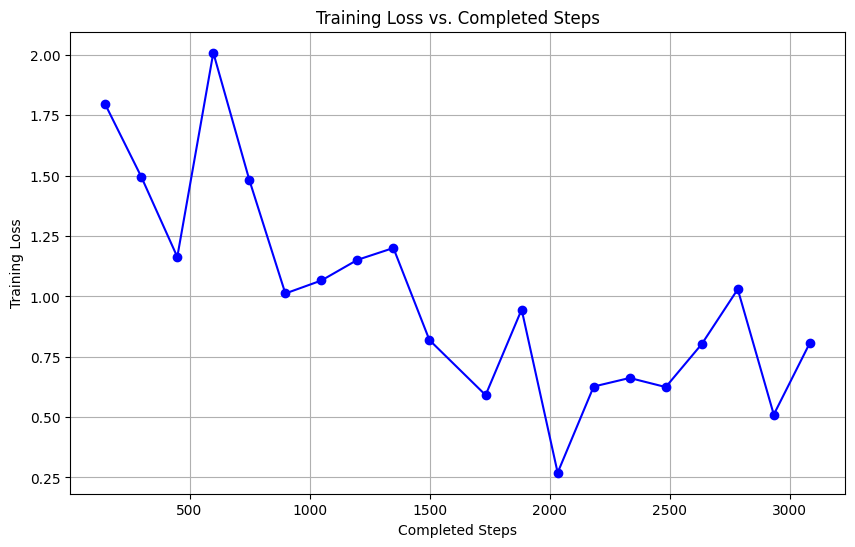

In [29]:
import matplotlib.pyplot as plt

# What a low-tech way to store the training losses and plot - I know...
# I forgot to keep track while training  - pls forgive me!

# extracted list of tuples with each element containing completed_steps and train_loss
# Data extracted
data = [
    (149, 1.79549241065979),
    (299, 1.495582103729248),
    (449, 1.1635879278182983),
    (599, 2.0094125270843506),
    (749, 1.4823153018951416),
    (899, 1.0121257305145264),
    (1049, 1.0659204721450806),
    (1199, 1.1513829231262207),
    (1349, 1.200542688369751),
    (1499, 0.8191907405853271),
    (1733, 0.5911881327629089),
    (1883, 0.9456667900085449),
    (2033, 0.2696741223335266),
    (2183, 0.6266515851020813),
    (2333, 0.6621687412261963),
    (2483, 0.6244927644729614),
    (2633, 0.8024786710739136),
    (2783, 1.0297491550445557),
    (2933, 0.5104318857192993),
    (3083, 0.8068967461585999)
]

# Unpack data into two lists
completed_steps, train_loss = zip(*data)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(completed_steps, train_loss, marker='o', linestyle='-', color='b')
plt.xlabel('Completed Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Completed Steps')
plt.grid(True)
plt.show()

In [28]:
print(compute_metrics(model, valid_loader, dataset_squad_valid, metric))

Eval progress: 100%|██████████| 160/160 [01:59<00:00,  1.34steps/s]


{'exact_match': 71.1, 'f1': 80.62985630352878}


# Saving the model

In [27]:
model.save_pretrained("/home/nguyenthuan49/HF_NLP_course/question-answering/fine-tuned-bert-squad")


# Inference

In [31]:
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import default_data_collator


question = "How did the military found dead bodies?"
context = """The Israeli military said on Saturday that it had found a number of dead bodies during an operation in the Gaza Strip, asking the Israeli public to refrain from speculation about their identities.

The announcement was widely interpreted in Israel, however, as confirmation that more Israeli hostages had died in captivity, and it quickly amplified calls for an immediate cease-fire in order to free the roughly 100 captives still held, both dead and alive, in Gaza."""

def find_answer_span(question, context, model, tokenizer):
    inference_batch = Dataset.from_dict({
        "id": ["00"],
        "question": [question],
        "context": [context]
    })

    tokenized_inference_batch = inference_batch.map(tokenize_and_map_to_original_example_ids,
                                                                    batched=True,
                                                                    remove_columns=inference_batch.column_names,
                                                                    )
    
    def custom_collator(batch):
        # Extract the "example_id"
        example_ids = [ex["example_id"] for ex in batch]
        # Use the default data collator to collate
        tensor_batch = default_data_collator(batch)
        # Add the "example_id" back to the collated batch
        tensor_batch["example_id"] = example_ids
        return tensor_batch

    inference_loader: DataLoader = DataLoader(dataset=tokenized_inference_batch,
                                        batch_size=10,
                                        shuffle=False,
                                        collate_fn=custom_collator)

    # print(compute_metrics(model, train_loader_for_validation, dataset_squad_train, metric))
    predicted_answers_dict = evaluate_batch(iter(inference_loader).__next__(), model, tokenizer)
    return (predicted_answers_dict['00'])

predicted_answer = find_answer_span(question, context, model, tokenizer)
print(f"QUESTION: {question}")
print(f"\nCONTEXT: {context}")
print(f"\nANSWER: {predicted_answer}")

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

QUESTION: How did the military found dead bodies?

CONTEXT: The Israeli military said on Saturday that it had found a number of dead bodies during an operation in the Gaza Strip, asking the Israeli public to refrain from speculation about their identities.

The announcement was widely interpreted in Israel, however, as confirmation that more Israeli hostages had died in captivity, and it quickly amplified calls for an immediate cease-fire in order to free the roughly 100 captives still held, both dead and alive, in Gaza.

ANSWER: during an operation in the Gaza Strip


In [32]:
question = "What was found?"
context = """The Israeli military said on Saturday that it had found a number of dead bodies during an operation in the Gaza Strip, asking the Israeli public to refrain from speculation about their identities.

The announcement was widely interpreted in Israel, however, as confirmation that more Israeli hostages had died in captivity, and it quickly amplified calls for an immediate cease-fire in order to free the roughly 100 captives still held, both dead and alive, in Gaza."""

predicted_answer = find_answer_span(question, context, model, tokenizer)
print(f"QUESTION: {question}")
print(f"\nCONTEXT: {context}")
print(f"\nANSWER: {predicted_answer}")

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

QUESTION: What was found?

CONTEXT: The Israeli military said on Saturday that it had found a number of dead bodies during an operation in the Gaza Strip, asking the Israeli public to refrain from speculation about their identities.

The announcement was widely interpreted in Israel, however, as confirmation that more Israeli hostages had died in captivity, and it quickly amplified calls for an immediate cease-fire in order to free the roughly 100 captives still held, both dead and alive, in Gaza.

ANSWER: a number of dead bodies


In [33]:
question = "What was the public not supposed to do?"
context = """The Israeli military said on Saturday that it had found a number of dead bodies during an operation in the Gaza Strip, asking the Israeli public to refrain from speculation about their identities.

The announcement was widely interpreted in Israel, however, as confirmation that more Israeli hostages had died in captivity, and it quickly amplified calls for an immediate cease-fire in order to free the roughly 100 captives still held, both dead and alive, in Gaza."""

predicted_answer = find_answer_span(question, context, model, tokenizer)
print(f"QUESTION: {question}")
print(f"\nCONTEXT: {context}")
print(f"\nANSWER: {predicted_answer}")

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

QUESTION: What was the public not supposed to do?

CONTEXT: The Israeli military said on Saturday that it had found a number of dead bodies during an operation in the Gaza Strip, asking the Israeli public to refrain from speculation about their identities.

The announcement was widely interpreted in Israel, however, as confirmation that more Israeli hostages had died in captivity, and it quickly amplified calls for an immediate cease-fire in order to free the roughly 100 captives still held, both dead and alive, in Gaza.

ANSWER: speculation about their identities


In [34]:
question = "What became more urgent after this announcement?"
context = """The Israeli military said on Saturday that it had found a number of dead bodies during an operation in the Gaza Strip, asking the Israeli public to refrain from speculation about their identities.

The announcement was widely interpreted in Israel, however, as confirmation that more Israeli hostages had died in captivity, and it quickly amplified calls for an immediate cease-fire in order to free the roughly 100 captives still held, both dead and alive, in Gaza."""

predicted_answer = find_answer_span(question, context, model, tokenizer)
print(f"QUESTION: {question}")
print(f"\nCONTEXT: {context}")
print(f"\nANSWER: {predicted_answer}")

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

QUESTION: What became more urgent after this announcement?

CONTEXT: The Israeli military said on Saturday that it had found a number of dead bodies during an operation in the Gaza Strip, asking the Israeli public to refrain from speculation about their identities.

The announcement was widely interpreted in Israel, however, as confirmation that more Israeli hostages had died in captivity, and it quickly amplified calls for an immediate cease-fire in order to free the roughly 100 captives still held, both dead and alive, in Gaza.

ANSWER: cease - fire


In [35]:
question = "What's the situation like for Ukraine at the moment?"
context = """President Volodymyr Zelensky of Ukraine on Wednesday was poised to undertake the biggest shake-up of his government since Russia's full-scale invasion, with half a dozen senior figures offering to resign, as Russian forces carried out a second day of deadly attacks in the early morning.

Dmytro Kuleba, the foreign minister, has offered to resign as have at least six others, according to the speaker of Ukraine's Parliament. Mr. Zelensky said Tuesday that “personnel decisions have been prepared” to fortify his government in the war. The restructuring comes at a precarious moment for Ukraine in the war, with heavy Russian assaults on the eastern front near the transit hub of Pokrovsk."""

predicted_answer = find_answer_span(question, context, model, tokenizer)
print(f"QUESTION: {question}")
print(f"\nCONTEXT: {context}")
print(f"\nANSWER: {predicted_answer}")

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

QUESTION: What's the situation like for Ukraine at the moment?

CONTEXT: President Volodymyr Zelensky of Ukraine on Wednesday was poised to undertake the biggest shake-up of his government since Russia's full-scale invasion, with half a dozen senior figures offering to resign, as Russian forces carried out a second day of deadly attacks in the early morning.

Dmytro Kuleba, the foreign minister, has offered to resign as have at least six others, according to the speaker of Ukraine's Parliament. Mr. Zelensky said Tuesday that “personnel decisions have been prepared” to fortify his government in the war. The restructuring comes at a precarious moment for Ukraine in the war, with heavy Russian assaults on the eastern front near the transit hub of Pokrovsk.

ANSWER: The restructuring comes at a precarious moment for Ukraine in the war


In [36]:
question = "Where's the war raging right now?"
context = """President Volodymyr Zelensky of Ukraine on Wednesday was poised to undertake the biggest shake-up of his government since Russia's full-scale invasion, with half a dozen senior figures offering to resign, as Russian forces carried out a second day of deadly attacks in the early morning.

Dmytro Kuleba, the foreign minister, has offered to resign as have at least six others, according to the speaker of Ukraine's Parliament. Mr. Zelensky said Tuesday that “personnel decisions have been prepared” to fortify his government in the war. The restructuring comes at a precarious moment for Ukraine in the war, with heavy Russian assaults on the eastern front near the transit hub of Pokrovsk."""

predicted_answer = find_answer_span(question, context, model, tokenizer)
print(f"QUESTION: {question}")
print(f"\nCONTEXT: {context}")
print(f"\nANSWER: {predicted_answer}")

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

QUESTION: Where's the war raging right now?

CONTEXT: President Volodymyr Zelensky of Ukraine on Wednesday was poised to undertake the biggest shake-up of his government since Russia's full-scale invasion, with half a dozen senior figures offering to resign, as Russian forces carried out a second day of deadly attacks in the early morning.

Dmytro Kuleba, the foreign minister, has offered to resign as have at least six others, according to the speaker of Ukraine's Parliament. Mr. Zelensky said Tuesday that “personnel decisions have been prepared” to fortify his government in the war. The restructuring comes at a precarious moment for Ukraine in the war, with heavy Russian assaults on the eastern front near the transit hub of Pokrovsk.

ANSWER: Pokrovsk


In [40]:
question = "What job positions are going to be vacated soon?"
context = """President Volodymyr Zelensky of Ukraine on Wednesday was poised to undertake the biggest shake-up of his government since Russia's full-scale invasion, with half a dozen senior figures offering to resign, as Russian forces carried out a second day of deadly attacks in the early morning.

Dmytro Kuleba, the foreign minister, has offered to resign as have at least six others, according to the speaker of Ukraine's Parliament. Mr. Zelensky said Tuesday that “personnel decisions have been prepared” to fortify his government in the war. The restructuring comes at a precarious moment for Ukraine in the war, with heavy Russian assaults on the eastern front near the transit hub of Pokrovsk."""

predicted_answer = find_answer_span(question, context, model, tokenizer)
print(f"QUESTION: {question}")
print(f"\nCONTEXT: {context}")
print(f"\nANSWER: {predicted_answer}")

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

QUESTION: What job positions are going to be vacated soon?

CONTEXT: President Volodymyr Zelensky of Ukraine on Wednesday was poised to undertake the biggest shake-up of his government since Russia's full-scale invasion, with half a dozen senior figures offering to resign, as Russian forces carried out a second day of deadly attacks in the early morning.

Dmytro Kuleba, the foreign minister, has offered to resign as have at least six others, according to the speaker of Ukraine's Parliament. Mr. Zelensky said Tuesday that “personnel decisions have been prepared” to fortify his government in the war. The restructuring comes at a precarious moment for Ukraine in the war, with heavy Russian assaults on the eastern front near the transit hub of Pokrovsk.

ANSWER: foreign minister


In [41]:
question = "How did the US comment on this development?"
context = """American and Iraqi commandos raided several Islamic State hide-outs in western Iraq last week, killing at least 14 ISIS fighters in one of the most sweeping counterterrorism missions in the country in recent years.

Seven U.S. soldiers were injured as more than 200 troops from both countries, including backup forces, hunted down fighters in bunkers over miles of remote terrain, U.S. and Iraqi officials said, adding that the size, scope and focus of the mission underscored the terrorist organization's resurgence in recent months.

A senior insurgent commander overseeing Islamic State operations in the Middle East and Europe was the main target, they said.

“The operation targeted ISIS leaders with the objective of disrupting and degrading ISIS's ability to plan, organize, and conduct attacks against Iraqi civilians, as well as U.S., allies and partners throughout the region and beyond,” the military's Central Command said in a statement on Sunday."""

predicted_answer = find_answer_span(question, context, model, tokenizer)
print(f"QUESTION: {question}")
print(f"\nCONTEXT: {context}")
print(f"\nANSWER: {predicted_answer}")

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

QUESTION: How did the US comment on this development?

CONTEXT: American and Iraqi commandos raided several Islamic State hide-outs in western Iraq last week, killing at least 14 ISIS fighters in one of the most sweeping counterterrorism missions in the country in recent years.

Seven U.S. soldiers were injured as more than 200 troops from both countries, including backup forces, hunted down fighters in bunkers over miles of remote terrain, U.S. and Iraqi officials said, adding that the size, scope and focus of the mission underscored the terrorist organization's resurgence in recent months.

A senior insurgent commander overseeing Islamic State operations in the Middle East and Europe was the main target, they said.

“The operation targeted ISIS leaders with the objective of disrupting and degrading ISIS's ability to plan, organize, and conduct attacks against Iraqi civilians, as well as U.S., allies and partners throughout the region and beyond,” the military's Central Command said i

In [44]:
question = "What was the purpose of this operation?"
context = """American and Iraqi commandos raided several Islamic State hide-outs in western Iraq last week, killing at least 14 ISIS fighters in one of the most sweeping counterterrorism missions in the country in recent years.

Seven U.S. soldiers were injured as more than 200 troops from both countries, including backup forces, hunted down fighters in bunkers over miles of remote terrain, U.S. and Iraqi officials said, adding that the size, scope and focus of the mission underscored the terrorist organization's resurgence in recent months.

A senior insurgent commander overseeing Islamic State operations in the Middle East and Europe was the main target, they said.

“The operation targeted ISIS leaders with the objective of disrupting and degrading ISIS's ability to plan, organize, and conduct attacks against Iraqi civilians, as well as U.S., allies and partners throughout the region and beyond,” the military's Central Command said in a statement on Sunday."""

predicted_answer = find_answer_span(question, context, model, tokenizer)
print(f"QUESTION: {question}")
print(f"\nCONTEXT: {context}")
print(f"\nANSWER: {predicted_answer}")

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

QUESTION: What was the purpose of this operation?

CONTEXT: American and Iraqi commandos raided several Islamic State hide-outs in western Iraq last week, killing at least 14 ISIS fighters in one of the most sweeping counterterrorism missions in the country in recent years.

Seven U.S. soldiers were injured as more than 200 troops from both countries, including backup forces, hunted down fighters in bunkers over miles of remote terrain, U.S. and Iraqi officials said, adding that the size, scope and focus of the mission underscored the terrorist organization's resurgence in recent months.

A senior insurgent commander overseeing Islamic State operations in the Middle East and Europe was the main target, they said.

“The operation targeted ISIS leaders with the objective of disrupting and degrading ISIS's ability to plan, organize, and conduct attacks against Iraqi civilians, as well as U.S., allies and partners throughout the region and beyond,” the military's Central Command said in a 

In [49]:
question = "Where did somme people kill some other people?"
context = """American and Iraqi commandos raided several Islamic State hide-outs in western Iraq last week, killing at least 14 ISIS fighters in one of the most sweeping counterterrorism missions in the country in recent years.

Seven U.S. soldiers were injured as more than 200 troops from both countries, including backup forces, hunted down fighters in bunkers over miles of remote terrain, U.S. and Iraqi officials said, adding that the size, scope and focus of the mission underscored the terrorist organization's resurgence in recent months.

A senior insurgent commander overseeing Islamic State operations in the Middle East and Europe was the main target, they said.

“The operation targeted ISIS leaders with the objective of disrupting and degrading ISIS's ability to plan, organize, and conduct attacks against Iraqi civilians, as well as U.S., allies and partners throughout the region and beyond,” the military's Central Command said in a statement on Sunday."""

predicted_answer = find_answer_span(question, context, model, tokenizer)
print(f"QUESTION: {question}")
print(f"\nCONTEXT: {context}")
print(f"\nANSWER: {predicted_answer}")

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

QUESTION: Where did somme people kill some other people?

CONTEXT: American and Iraqi commandos raided several Islamic State hide-outs in western Iraq last week, killing at least 14 ISIS fighters in one of the most sweeping counterterrorism missions in the country in recent years.

Seven U.S. soldiers were injured as more than 200 troops from both countries, including backup forces, hunted down fighters in bunkers over miles of remote terrain, U.S. and Iraqi officials said, adding that the size, scope and focus of the mission underscored the terrorist organization's resurgence in recent months.

A senior insurgent commander overseeing Islamic State operations in the Middle East and Europe was the main target, they said.

“The operation targeted ISIS leaders with the objective of disrupting and degrading ISIS's ability to plan, organize, and conduct attacks against Iraqi civilians, as well as U.S., allies and partners throughout the region and beyond,” the military's Central Command sai